In [2]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
import nibabel as nib
import psutil
%matplotlib inline
from skimage.filters import threshold_triangle as triangle

from mpl_toolkits.axes_grid1 import ImageGrid
from scipy import ndimage

In [3]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"

In [4]:
flies = ['fly_089', 'fly_094', 'fly_100']

In [ ]:
t0 = time.time()
directory = os.path.join(dataset_path, 'fly_094','func_0', 'pca', '20200922_on_high_pass_masked')
file = os.path.join(directory, 'scores_(spatial).npy')
pca_spatial = np.load(file)
file = os.path.join(directory, 'loadings_(temporal).npy')
pca_loadings = np.load(file)
#pca_spatial.shape = (4554, -1)
#pca_spatial.shape = (4554, 128, 84, 49)
print('Duration: {}'.format(time.time()-t0))

In [4]:
pca_spatial.shape

(3384, 256, 128, 49)

In [58]:
first_50 = pca_spatial[:50,:,:,:]

In [43]:
first_50.shape

(50, 256, 128, 49)

In [ ]:
directory = os.path.join(dataset_path, 'fly_094', 'func_0')
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac = bbb.load_fictrac(os.path.join(directory, 'fictrac'))

In [27]:
from scipy.interpolate import interp1d


In [28]:
def interp_fictrac(fictrac, fps, resolution, expt_len, timestamps):
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    
    x_original = np.arange(0,expt_len,camera_rate)
    
    dx = np.asarray(fictrac['dRotLabX'])
    dy = np.asarray(fictrac['dRotLabY'])
    dz = np.asarray(fictrac['dRotLabZ'])
    dx = scipy.signal.savgol_filter(dx,25,3)
    dy = scipy.signal.savgol_filter(dy,25,3)
    dz = scipy.signal.savgol_filter(dz,25,3)
    fictrac_smoothed = np.sqrt(dx*dx + dy*dy + dz*dz)
    
    fictrac_smoothed = np.abs(fictrac_smoothed)
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    fictrac_interp = fictrac_interp_temp(timestamps[:,25])

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

resolution = 10 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
fictrac_interp = interp_fictrac(fictrac, fps, resolution, expt_len, timestamps)
xnew = np.arange(0,expt_len,resolution)

In [29]:
fictrac_interp.shape

(3384,)

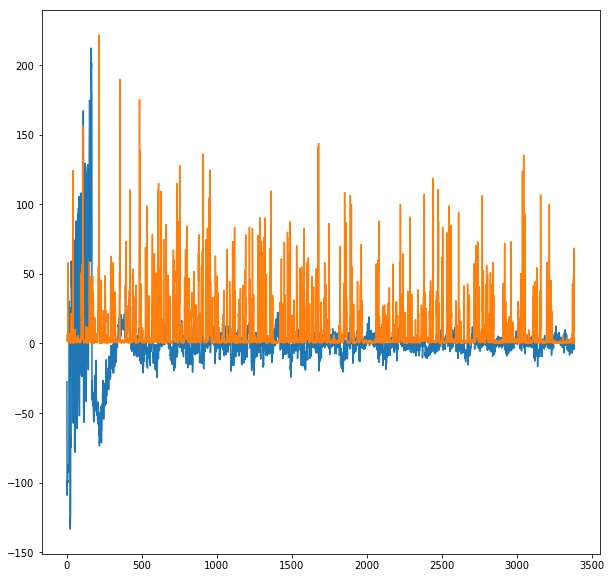

In [63]:
fig = plt.figure(figsize=(10,10))
plt.plot(pca_loadings[:,2]);
plt.plot(fictrac_interp*1000)
#plt.xlim(1000,2000)

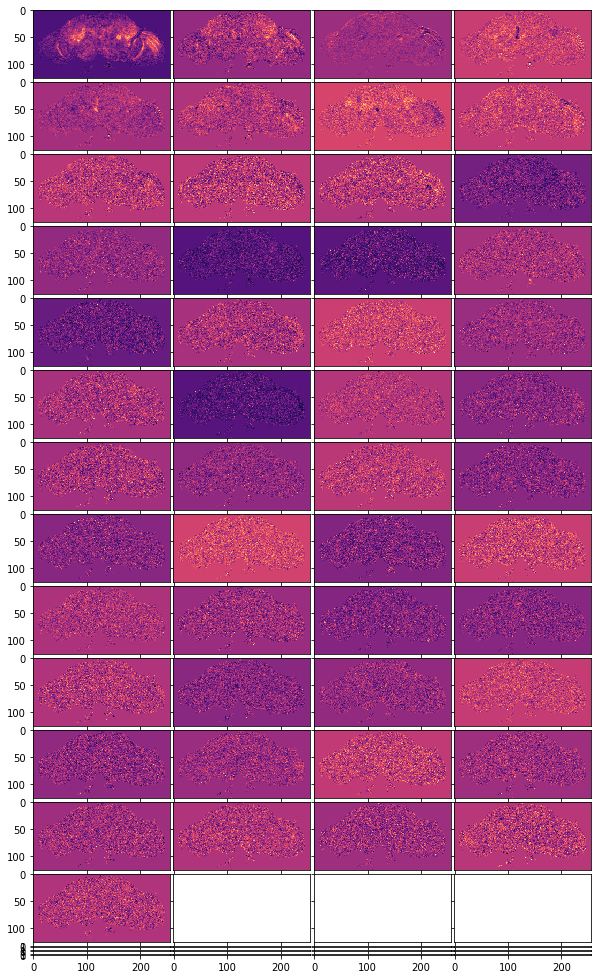

In [10]:
fig = plt.figure(figsize=(10,20))
grid = ImageGrid(fig, 111, nrows_ncols=(16, 4), axes_pad=.05)
for i in range(49):
    grid[i].imshow(pca_spatial[i,:,:,10].T,cmap='magma')

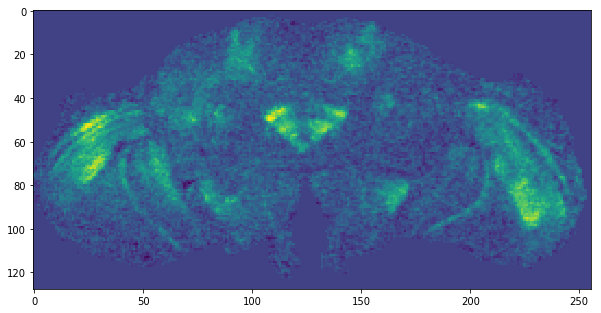

In [5]:
fig = plt.figure(figsize=(10,10))
plt.imshow(pca_spatial[0,:,:,20].T)

In [3]:
# FINALLY, THIS ONE WORKS
directory = os.path.join(dataset_path, 'fly_094','func_0')
brain_file = os.path.join(directory, 'brain_zscored_green.nii')
brain_high_pass = np.array(nib.load(brain_file).get_data(), copy=True)

In [4]:
directory = os.path.join(dataset_path, 'fly_094','func_0', 'imaging')
brain_file = os.path.join(directory, 'functional_channel_2.nii')
brain_raw = np.array(nib.load(brain_file).get_data(), copy=True)

In [8]:
directory = os.path.join(dataset_path, 'fly_094','func_0', 'imaging')
brain_file = os.path.join(directory, 'functional_channel_2_mean.nii')
brain_direct_mean = np.array(nib.load(brain_file).get_data(), copy=True)

In [9]:
threshold = triangle(brain_direct_mean)
brain_direct_mean[np.where(brain_direct_mean < threshold/1.3)] = 0

In [5]:
brain_mean = np.mean(brain_raw, axis=-1)

threshold = triangle(brain_mean)
brain_mean[np.where(brain_mean < threshold/1.3)] = 0

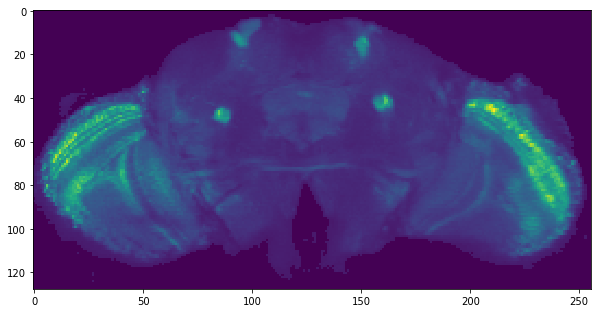

In [10]:
fig = plt.figure(figsize=(10,10))
plt.imshow(brain_direct_mean[:,:,20].T)

In [5]:
brain_mean = np.mean(brain_raw, axis=-1)

threshold = triangle(brain_mean)
brain_mean[np.where(brain_mean < threshold/1.3)] = 0

labels, label_nb = scipy.ndimage.label(brain_mean)
brain_label = np.bincount(labels.flatten())[1:].argmax()+1

mask = np.ones(brain_mean.shape)
mask[np.where(labels != brain_label)] = 0 # np.nan here failed with PCA

brain_high_pass_masked = brain_high_pass*mask[:,:,:,None]

In [6]:
file = os.path.join(dataset_path, 'fly_094','func_0', 'brain_zscored_green_masked.nii')
nib.Nifti1Image(brain_high_pass_masked, np.eye(4)).to_filename(file)

In [61]:
first_50.shape

(256, 128, 49, 50)

In [60]:
first_50 = np.moveaxis(first_50, 0,-1)

In [62]:
file = os.path.join(dataset_path, 'fly_094','func_0', 'temp_4_viewing.nii')
nib.Nifti1Image(first_50, np.eye(4)).to_filename(file)

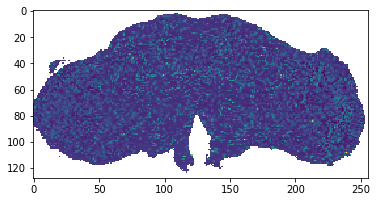

In [33]:
plt.imshow(brain_high_pass_masked[:,:,20,100].T)

In [30]:
brain_high_pass_masked.shape

(256, 128, 49, 3384)

In [9]:
np.where(labels != brain_label)[0].shape

(772172,)

In [11]:
np.where(labels != brain_label)

(array([  0,   0,   0, ..., 255, 255, 255]),
 array([  0,   0,   0, ..., 127, 127, 127]),
 array([ 0,  1,  2, ..., 46, 47, 48]))

In [25]:
mask = np.ones(brain_mean.shape)
mask[np.where(labels != brain_label)] = np.nan

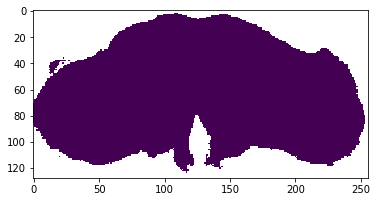

In [26]:
plt.imshow(mask[:,:,20].T)

In [6]:
brain_high_pass.shape

(256, 128, 49, 3384)

In [ ]:
brain_high_pass[np.where(labels != brain_label),0] = np.nan

In [ ]:
brain_high_pass.shape

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.imshow(brain_high_pass[:,:,20,0].T)

In [21]:
brain_high_pass[np.where(labels != brain_label),:] = np.nan

In [22]:
brain_mean_copy.shape

(256, 128, 49)

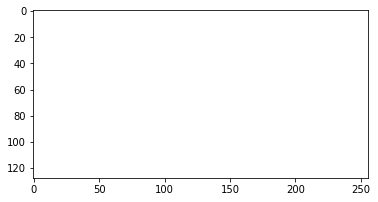

In [25]:
plt.imshow(brain_mean_copy[:,:,10].T)

In [ ]:
brain_high_pass[np.where(labels != brain_label),:] = np.nan

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.imshow(brain_high_pass[:,:,20,1000].T)

In [10]:
brain_copy = brain_mean.copy().astype('float32')
threshold = triangle(brain_copy)
brain_copy[np.where(brain_copy < threshold/1.3)] = 0

labels, label_nb = scipy.ndimage.label(brain_copy)
brain_label = np.bincount(labels.flatten())[1:].argmax()+1
brain_copy = brain_mean.copy().astype('float32')
brain_copy[np.where(labels != brain_label)] = np.nan

fig = plt.figure(figsize=(10,10))
plt.imshow(brain_copy[:,:,40].T)

(256, 128, 49, 3384)

In [7]:
brain_high_pass.shape

(256, 128, 49, 3384)

In [9]:
memory_usage = psutil.Process(os.getpid()).memory_info().rss*10**-9
print('Current memory usage: {:.2f}GB'.format(memory_usage))

Current memory usage: 33.22GB


In [31]:
directory = os.path.join(dataset_path, 'fly_094','func_0')
brain_file = os.path.join(directory, 'brain_zscored_green.nii')
brain_z_score = np.asarray(nib.load(brain_file).get_data(), dtype='float16').copy()

In [32]:
brain_z_score.shape

(256, 128, 49, 3384)

In [3]:
directory = os.path.join(dataset_path, 'fly_094','func_0')
#brain_file = os.path.join(directory, 'imaging', 'functional_channel_1.nii')
brain_file = os.path.join(directory, 'moco', 'stitched_brain_green.nii')
brain_raw = np.asarray(nib.load(brain_file).get_data(), dtype='float32')

In [4]:
directory = os.path.join(dataset_path, 'fly_5','func_0')
#brain_file = os.path.join(directory, 'imaging', 'functional_channel_1.nii')
brain_file = os.path.join(directory, 'brain_zscored_green.nii')
brain = np.asarray(nib.load(brain_file).get_data(), dtype='float16').copy()

In [4]:
brain_mean = np.mean(brain_raw,axis=-1)

In [5]:
brain_mean.shape

(256, 128, 49)

(array([1.200686e+06, 2.828770e+05, 6.821500e+04, 3.038200e+04,
        1.537700e+04, 5.882000e+03, 1.711000e+03, 3.810000e+02,
        9.800000e+01, 2.300000e+01]),
 array([ 111.85608673,  553.83180618,  995.80752563, 1437.78324509,
        1879.75896454, 2321.73468399, 2763.71040344, 3205.68612289,
        3647.66184235, 4089.6375618 , 4531.61328125]),
 <a list of 10 Patch objects>)

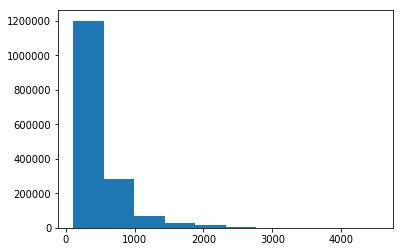

In [6]:
plt.hist(brain_mean.flatten())

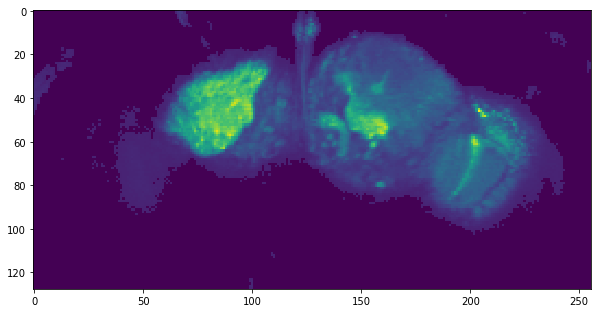

In [15]:
fig = plt.figure(figsize=(10,10))
plt.imshow(brain_mean[:,:,5].T)

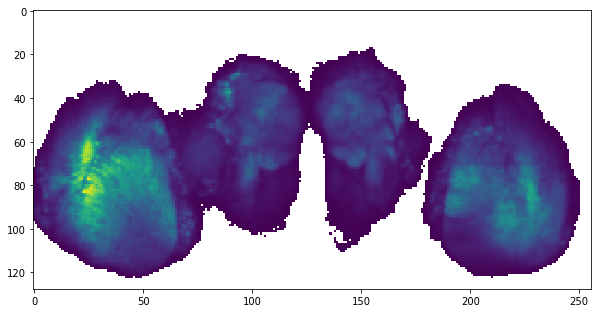

In [38]:
brain_copy = brain_mean.copy().astype('float32')
threshold = triangle(brain_copy)
brain_copy[np.where(brain_copy < threshold/1.3)] = 0

labels, label_nb = scipy.ndimage.label(brain_copy)
brain_label = np.bincount(labels.flatten())[1:].argmax()+1
brain_copy = brain_mean.copy().astype('float32')
brain_copy[np.where(labels != brain_label)] = np.nan

fig = plt.figure(figsize=(10,10))
plt.imshow(brain_copy[:,:,40].T)

In [20]:
brain_copy = brain_mean.copy().astype('float32')
threshold = triangle(brain_copy)
brain_copy[np.where(brain_copy < threshold/2)] = np.nan

In [15]:
brain_copy[:,:,23]

array([[198.92258, 218.26271, 220.02452, ..., 218.9737 , 218.71365,
        217.6779 ],
       [201.68617, 220.61111, 222.01152, ..., 222.09338, 222.29433,
        221.69296],
       [200.47252, 219.63504, 219.87943, ..., 220.71365, 219.97192,
        221.60284],
       ...,
       [208.26802, 217.46986, 218.84071, ..., 213.23936, 200.98817,
        190.48167],
       [200.39716, 210.52689, 210.73463, ..., 215.29019, 203.68115,
        192.77571],
       [      nan, 166.5727 , 166.25769, ...,       nan,       nan,
              nan]], dtype=float32)

In [10]:
brain_copy = brain_mean.copy().astype('float32')
threshold = triangle(brain_copy)
brain_copy[np.where(brain_copy < threshold/2)] = 0

In [12]:
labels, label_nb = scipy.ndimage.label(brain_copy)
brain_label = np.bincount(labels.flatten())[1:].argmax()+1
brain_copy = brain_mean.copy().astype('float32')
brain_copy[np.where(labels != brain_label)] = np.nan

In [6]:
print("Done")

Done


In [6]:
num_samples = 300

dim_1 = np.random.randint(0,256,num_samples)
dim_2 = np.random.randint(0,128,num_samples)
dim_3 = np.random.randint(0,49,num_samples)

samples = brain_high_pass[dim_1, dim_2, dim_3, :]

In [34]:
samples_high_pass = brain_high_pass[dim_1, dim_2, dim_3, :]
samples_z_score = brain_z_score[dim_1, dim_2, dim_3, :]

In [98]:
num_samples = 1000

dim_1 = np.random.randint(0,256,num_samples)
dim_2 = np.random.randint(0,128,num_samples)
dim_3 = np.random.randint(0,49,num_samples)

zscore_samples = brain_zscore[dim_1, dim_2, dim_3, :]
raw_samples = brain_raw[dim_1, dim_2, dim_3, :]

In [51]:
green_smoothed = gaussian_filter1d(green_samples,sigma=200,axis=-1,truncate=1)
red_smoothed = gaussian_filter1d(red_samples,sigma=200,axis=-1,truncate=1)

In [12]:
from scipy.ndimage import gaussian_filter1d

In [14]:
smoothed = gaussian_filter1d(samples.astype('float32'),sigma=200,axis=-1,truncate=1)

In [158]:
raw_smoothed_2sec = gaussian_filter1d(raw_samples,sigma=2,axis=-1,truncate=1)

In [53]:
green_smoothed.T.shape

(3384, 1000)

In [ ]:
#with a sigma of 200, this is 400 timepoints, each of which is ~.5sec, so smoothing over ~200sec or ~3min

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.plot(samples.T);

In [75]:
samples.T.shape

(3384, 100)

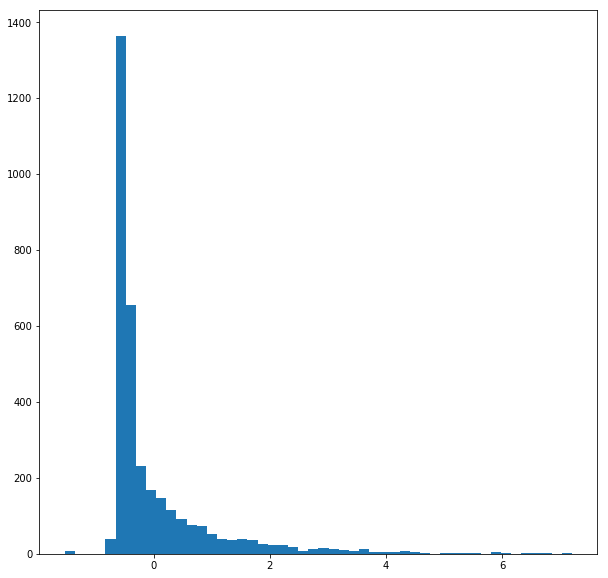

In [83]:
fig = plt.figure(figsize=(10,10))
plt.hist(samples.T[:,3].flatten(),bins=50);

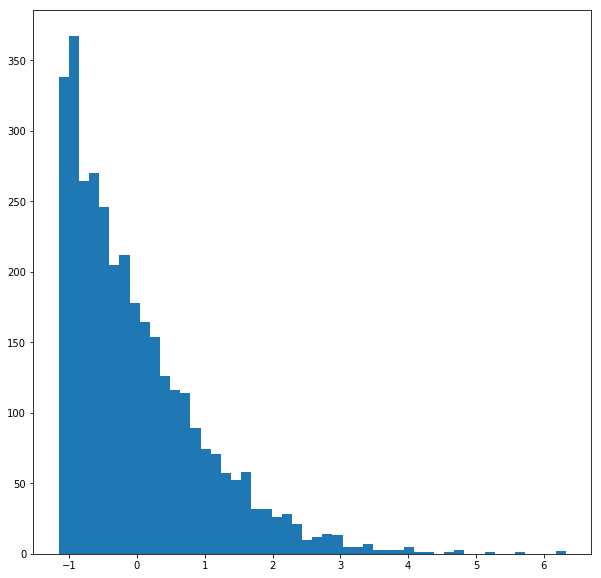

In [85]:
fig = plt.figure(figsize=(10,10))
plt.hist(samples.T[:,4].flatten(),bins=50);

In [101]:
zscore_samples.T.shape

(3384, 1000)

In [37]:
index = 207
dim_1[index], dim_2[index], dim_3[index]

(249, 126, 47)

In [145]:
brain_raw.shape

(256, 128, 49, 3384)

In [38]:
brain_mean = np.mean(np.abs(brain_z_score), axis=-1)

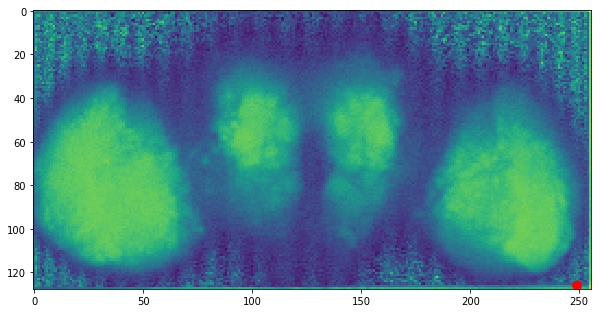

In [42]:
fig = plt.figure(figsize=(10,10))
plt.imshow(brain_mean[:,:,47].T.astype('float32'))
circle1 = plt.Circle((249, 126), 2, color='r')
ax = fig.gca()
ax.add_artist(circle1)

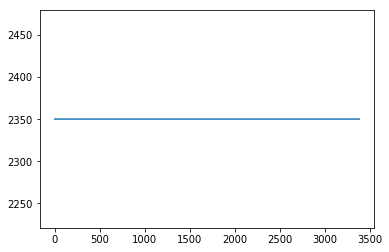

In [161]:
mean_signal = np.mean(raw_smoothed.T[:,index])
correction = mean_signal - raw_smoothed.T[:,index]
corrected = raw_smoothed.T[:,index] + correction
plt.plot(corrected)

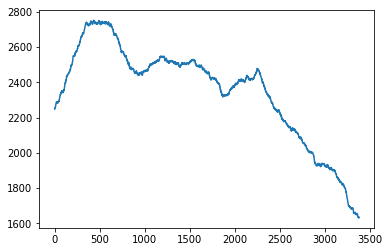

In [160]:
plt.plot(raw_smoothed.T[:,index])

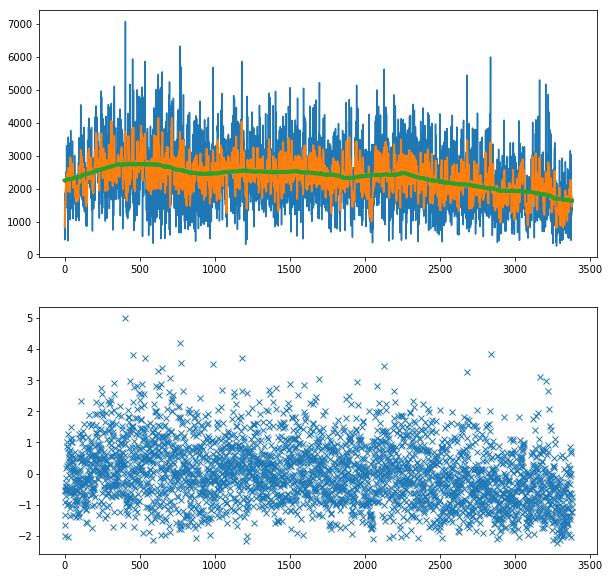

In [159]:
index = 26
fig = plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(raw_samples.T[:,index]);
plt.plot(raw_smoothed_2sec.T[:,index],linewidth=2);
plt.plot(raw_smoothed.T[:,index],linewidth=4);
plt.subplot(2,1,2)
plt.plot(zscore_samples.T[:,index],'x');

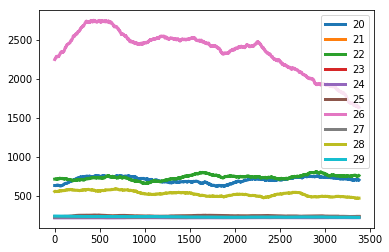

In [140]:
for i in range(20,30):
    plt.plot(raw_smoothed.T[:,i],linewidth=3,label=i);
plt.legend()

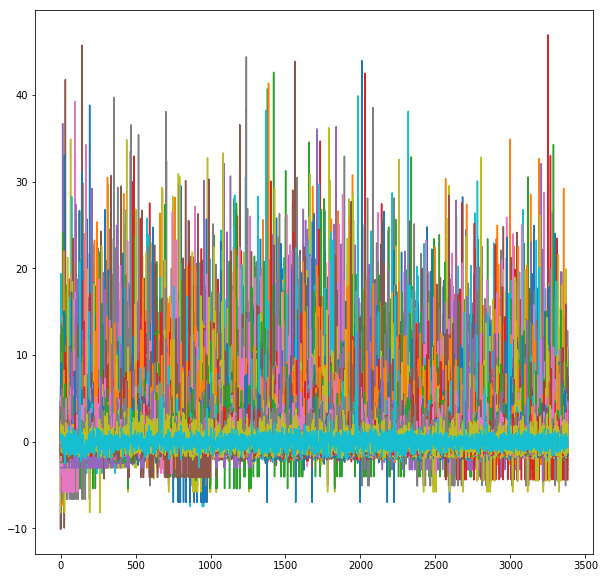

In [99]:
fig = plt.figure(figsize=(10,10))
plt.plot(zscore_samples.T);

In [24]:
np.argmax(smoothed)

701011

In [25]:
smoothed.shape

(300, 3384)

In [26]:
701011/3384

207.15455082742318

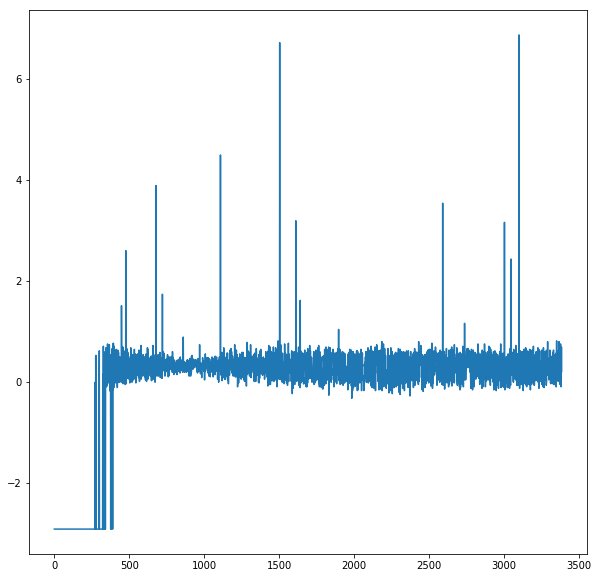

In [36]:
fig = plt.figure(figsize=(10,10))
plt.plot(samples_z_score.T[:,207]);

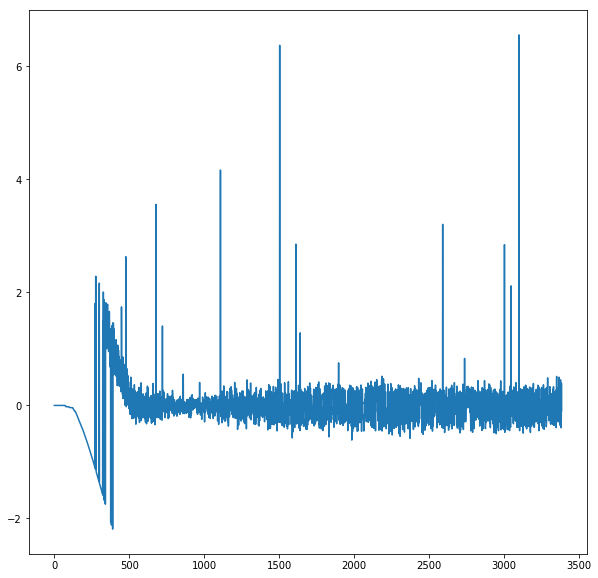

In [35]:
fig = plt.figure(figsize=(10,10))
plt.plot(samples_high_pass.T[:,207]);

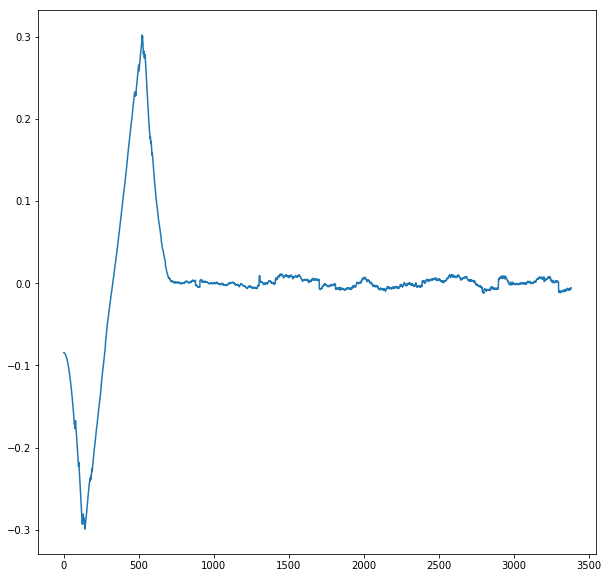

In [27]:
fig = plt.figure(figsize=(10,10))
#plt.plot(samples.T[:,14],'x');
plt.plot(smoothed.T[:,207]);

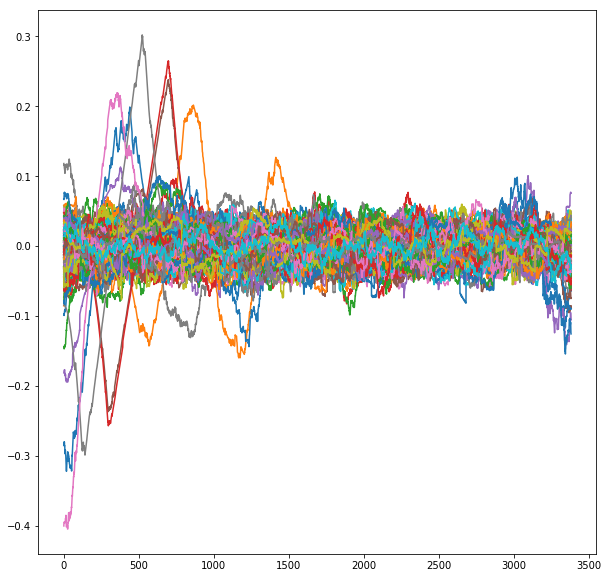

In [28]:
fig = plt.figure(figsize=(10,10))
#plt.plot(samples.T[:,14],'x');
plt.plot(smoothed.T);

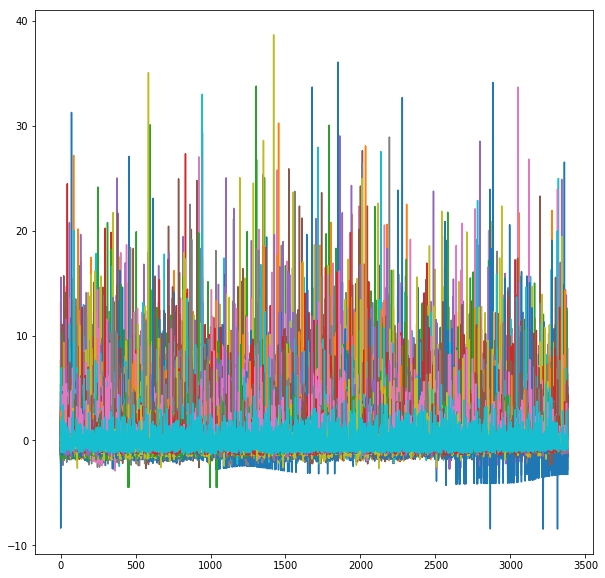

In [20]:
fig = plt.figure(figsize=(10,10))
plt.plot(samples.T);

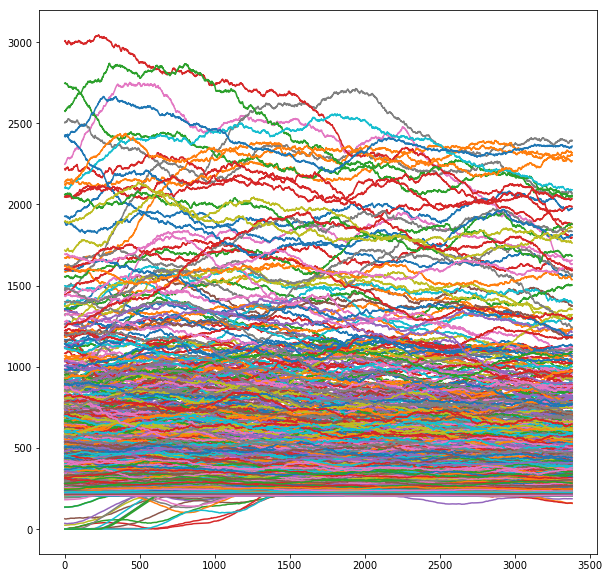

In [112]:
fig = plt.figure(figsize=(10,10))
plt.plot(raw_smoothed.T);

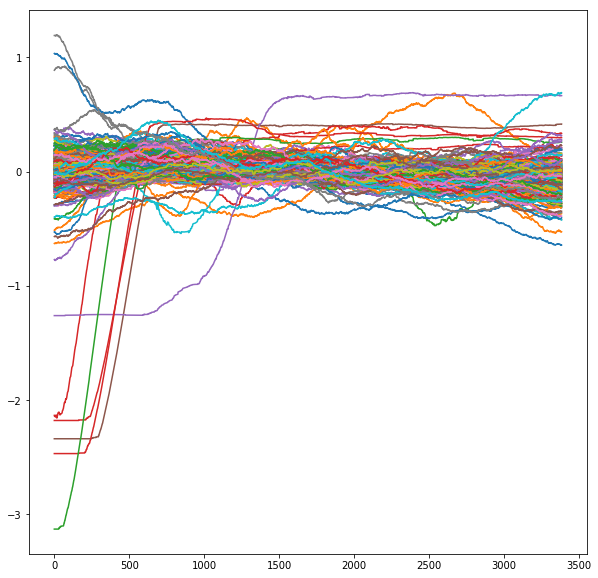

In [95]:
fig = plt.figure(figsize=(10,10))
plt.plot(smoothed.T);

In [8]:
samples.T.shape

(3384, 300)

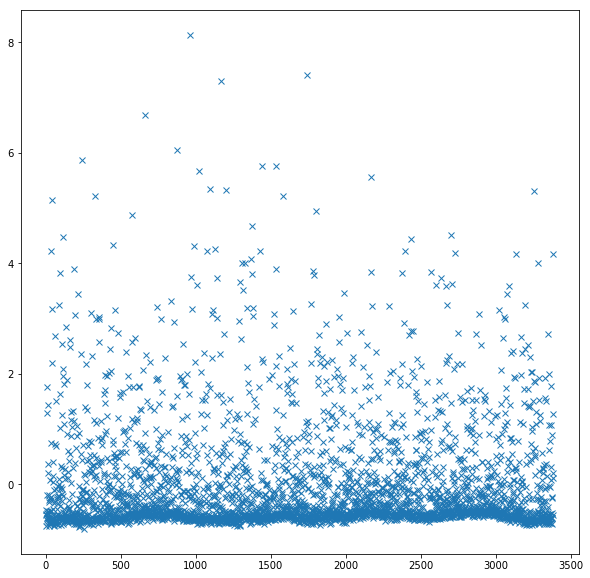

In [11]:
fig = plt.figure(figsize=(10,10))
plt.plot(samples.T[:,1],'x');

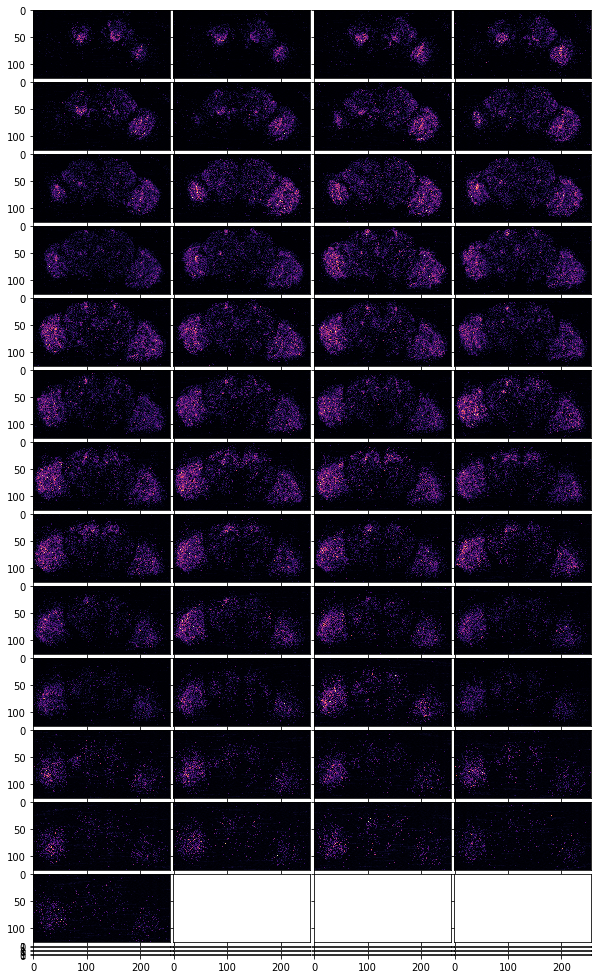

In [85]:
fig = plt.figure(figsize=(10,20))
grid = ImageGrid(fig, 111, nrows_ncols=(16, 4), axes_pad=.05)
for i in range(49):
    grid[i].imshow(brain[:,:,i,1000].T,cmap='magma')

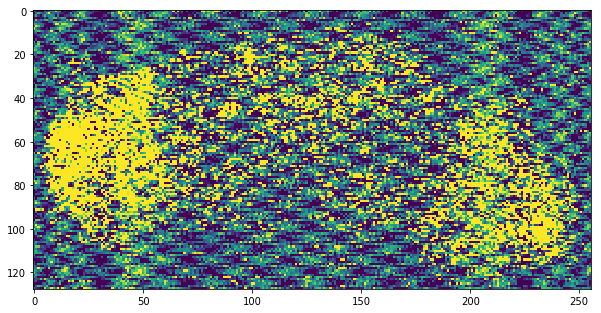

In [8]:
fig = plt.figure(figsize=(10,20))
#plt.imshow(brain[:,:,20,1000].T)
plt.imshow(brain[:,:,20,1000].T,vmin=200,vmax=250)

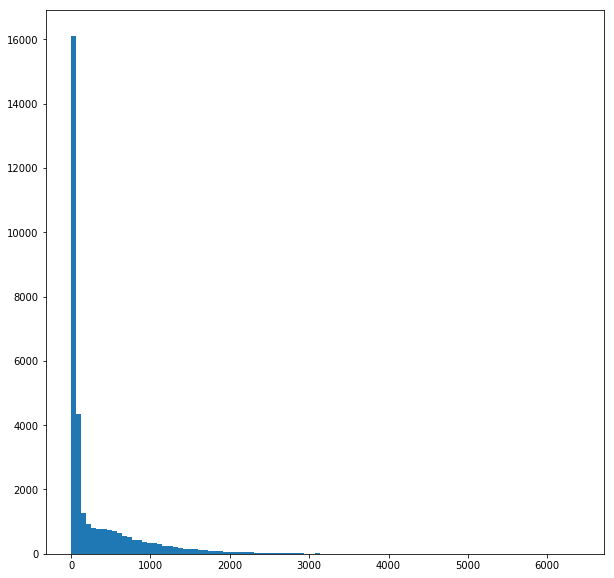

In [87]:
fig = plt.figure(figsize=(10,10))
plt.hist(brain[:,:,20,1000].flatten(),bins=100);

(0, 400)

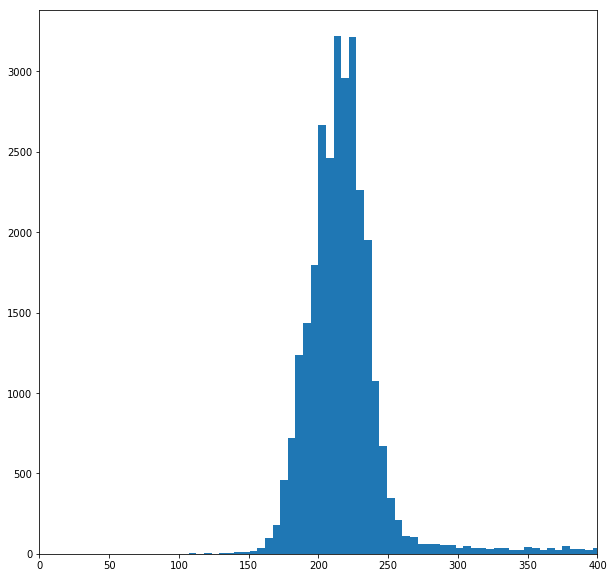

In [5]:
fig = plt.figure(figsize=(10,10))
plt.hist(brain[:,:,20,1000].flatten(),bins=1000);
plt.xlim(0,400)

In [8]:
pca_spatial.shape

(3384, 256, 128, 49)

In [10]:
out = np.max(np.abs(pca_spatial[:100,...]),axis=-1)

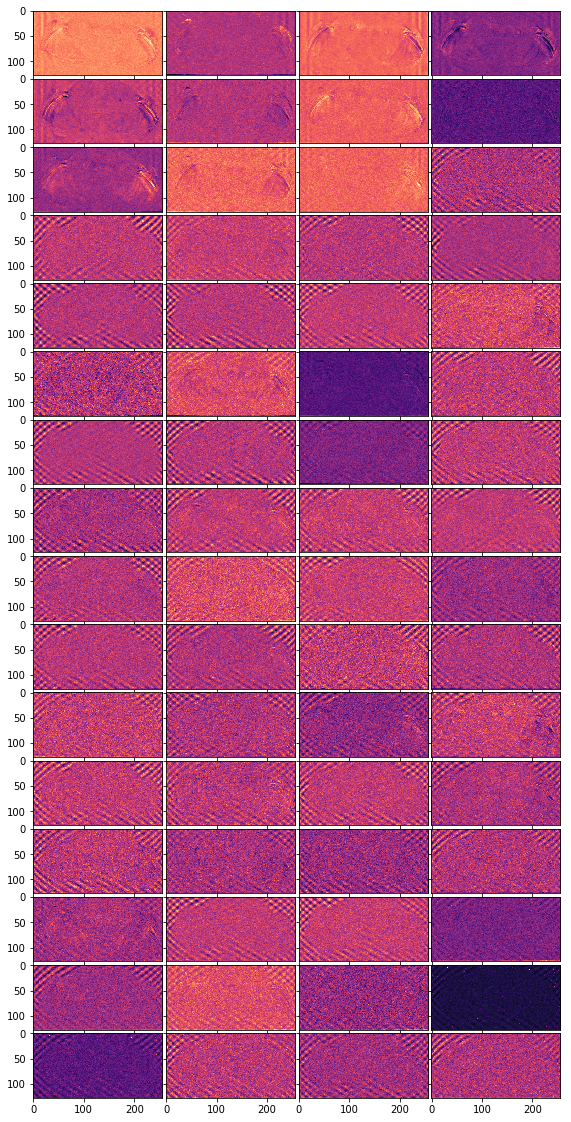

In [12]:
fig = plt.figure(figsize=(10,20))
grid = ImageGrid(fig, 111, nrows_ncols=(16, 4), axes_pad=.05)
for i in range(64):
    grid[i].imshow(pca_spatial[i,:,:,20].T,cmap='magma')

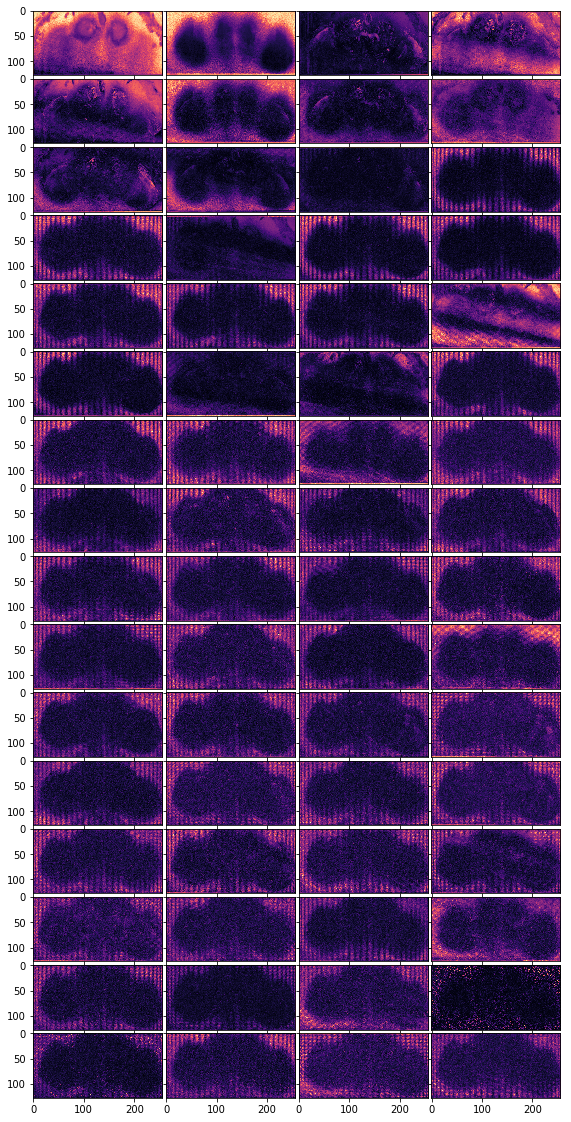

In [11]:
fig = plt.figure(figsize=(10,20))
grid = ImageGrid(fig, 111, nrows_ncols=(16, 4), axes_pad=.05)
for i in range(64):
    grid[i].imshow(out[i,:,:].T,cmap='magma')

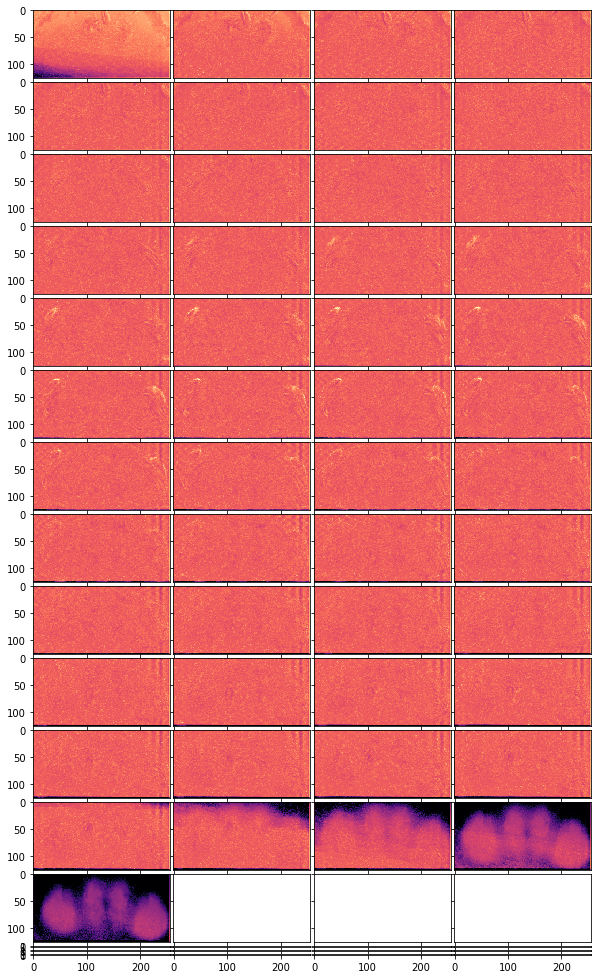

In [20]:
fig = plt.figure(figsize=(10,20))
grid = ImageGrid(fig, 111, nrows_ncols=(16, 4), axes_pad=.05)
for i in range(49):
    grid[i].imshow(pca_spatial[1,:,:,i].T,cmap='magma',vmin=-.004,vmax=.002)

In [13]:
pca_spatial.shape

(3384, 256, 128, 49)

(array([3.249000e+03, 1.078000e+04, 1.459700e+04, 1.858100e+04,
        1.591800e+04, 2.707500e+04, 1.409765e+06, 1.050440e+05,
        5.810000e+02, 4.200000e+01]),
 array([-0.0065498 , -0.00557548, -0.00460117, -0.00362685, -0.00265254,
        -0.00167823, -0.00070391,  0.0002704 ,  0.00124472,  0.00221903,
         0.00319335]),
 <a list of 10 Patch objects>)

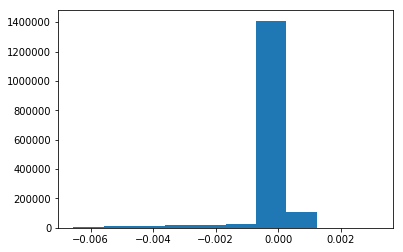

In [16]:
plt.hist(pca_spatial[0,:,:,:].flatten())